In [2]:
!pip install opencv-contrib.python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import cv2
from google.colab.patches import cv2_imshow

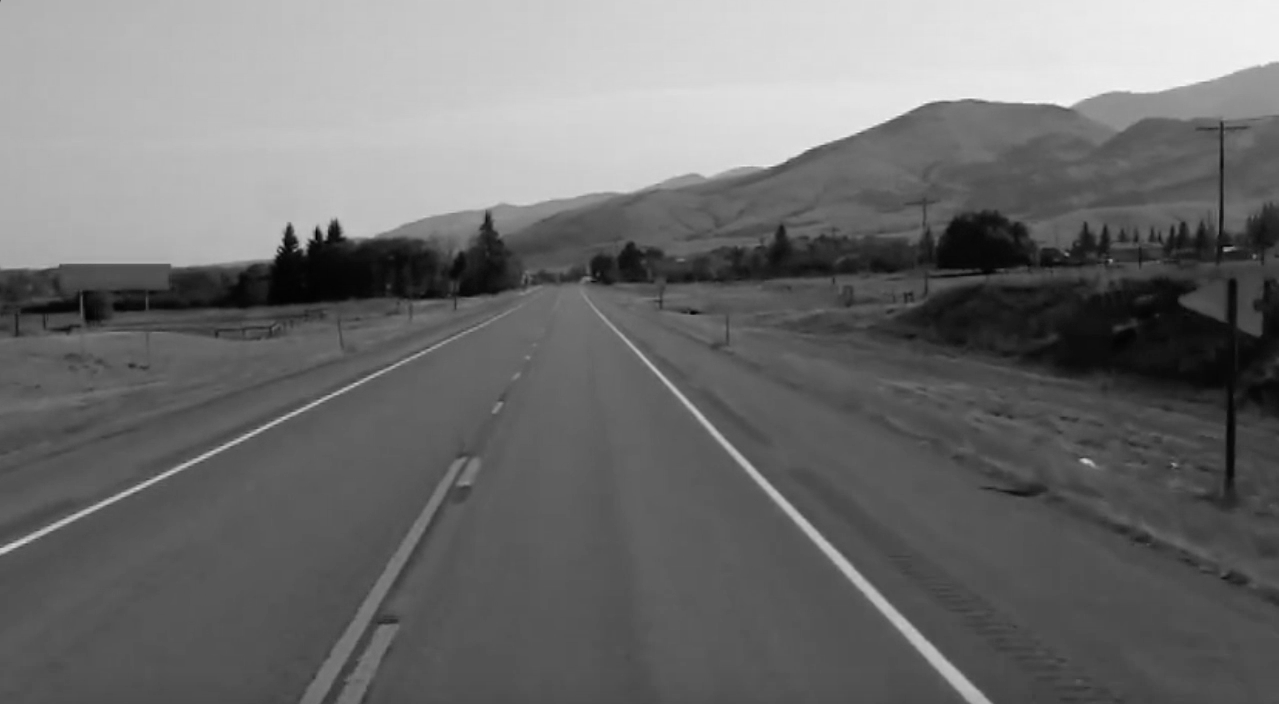

-1

In [5]:
image = cv2.imread("/content/drive/MyDrive/Automotive/test_image.jpg")
lane_image = np.copy(image)  #making copy of an image using numpy
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)  #converting image from colour to gray(3channel to 1 channel image)

cv2_imshow(gray)

cv2.waitKey(0)  #displaing image till any key is pressed

#Soothing image
Reduces the noice

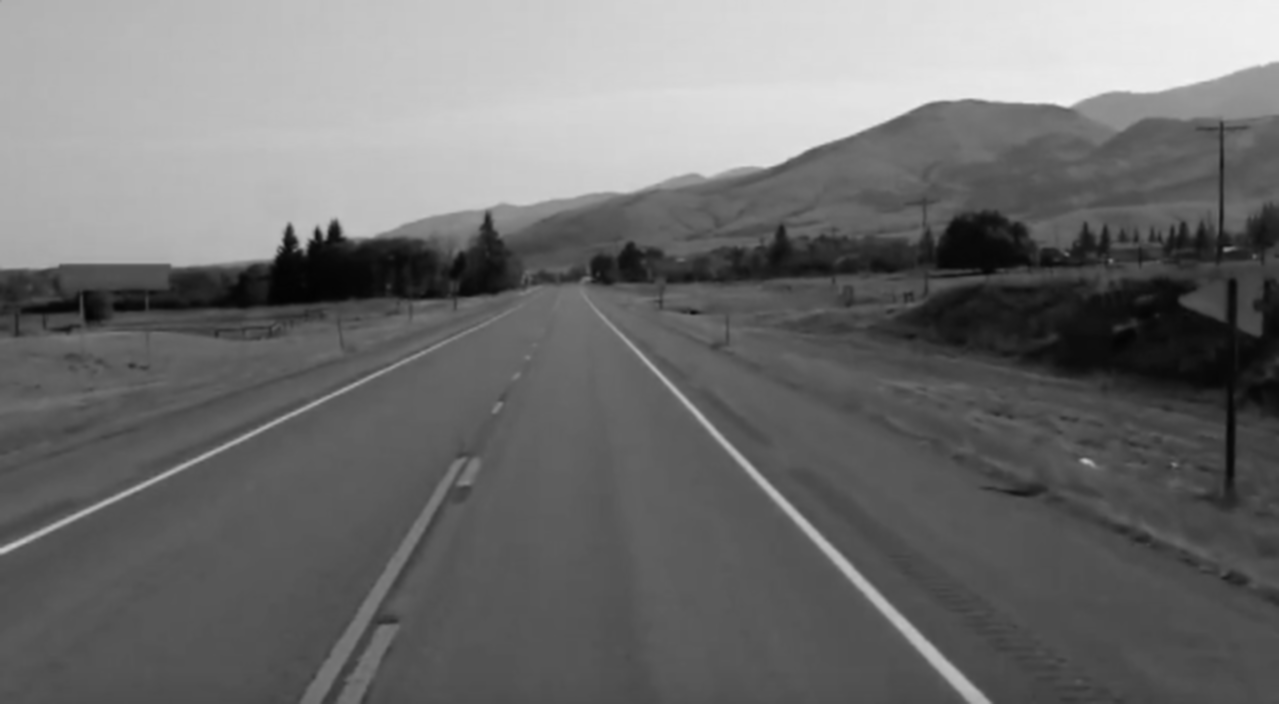

-1

In [6]:
blur=cv2.GaussianBlur(gray,(5,5),0)
cv2_imshow(blur)

cv2.waitKey(0)

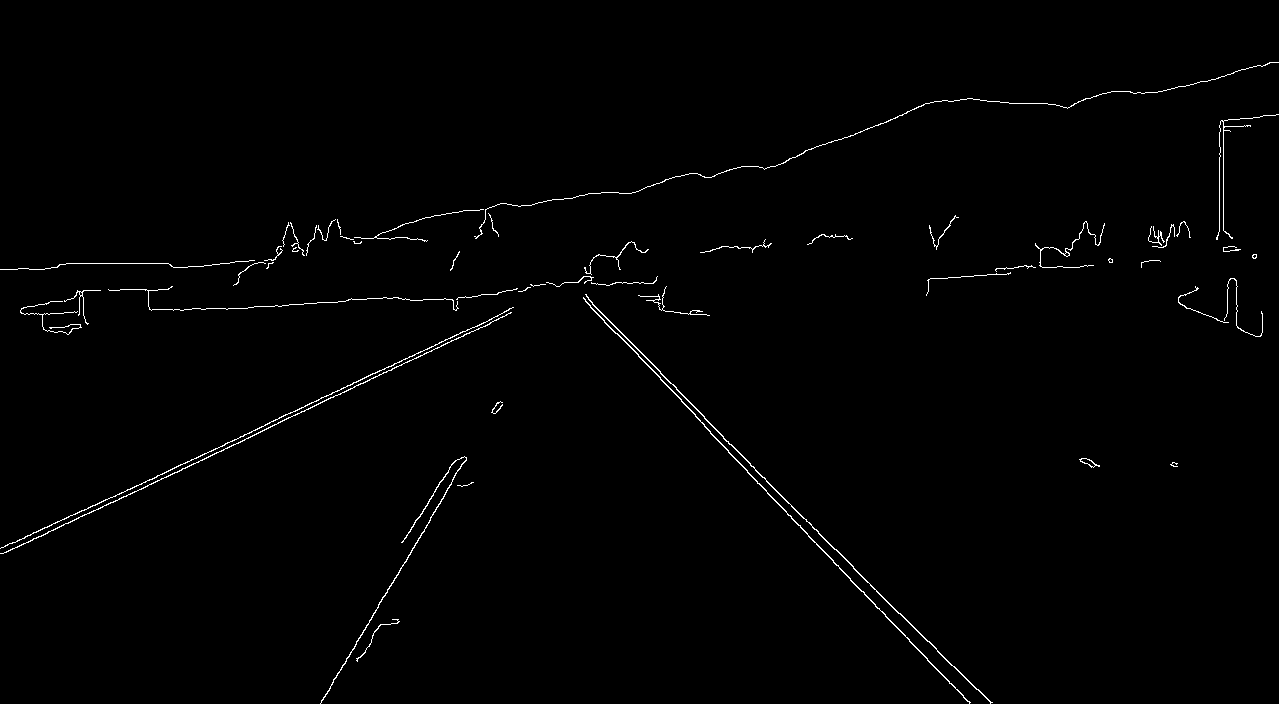

-1

In [7]:
canny=cv2.Canny(blur,50,150)

cv2_imshow(canny)

cv2.waitKey(0) 

In [43]:
def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = 5
    blur = cv2.GaussianBlur(gray,(kernel, kernel),0)
    canny = cv2.Canny(gray, 50, 150)
    return canny

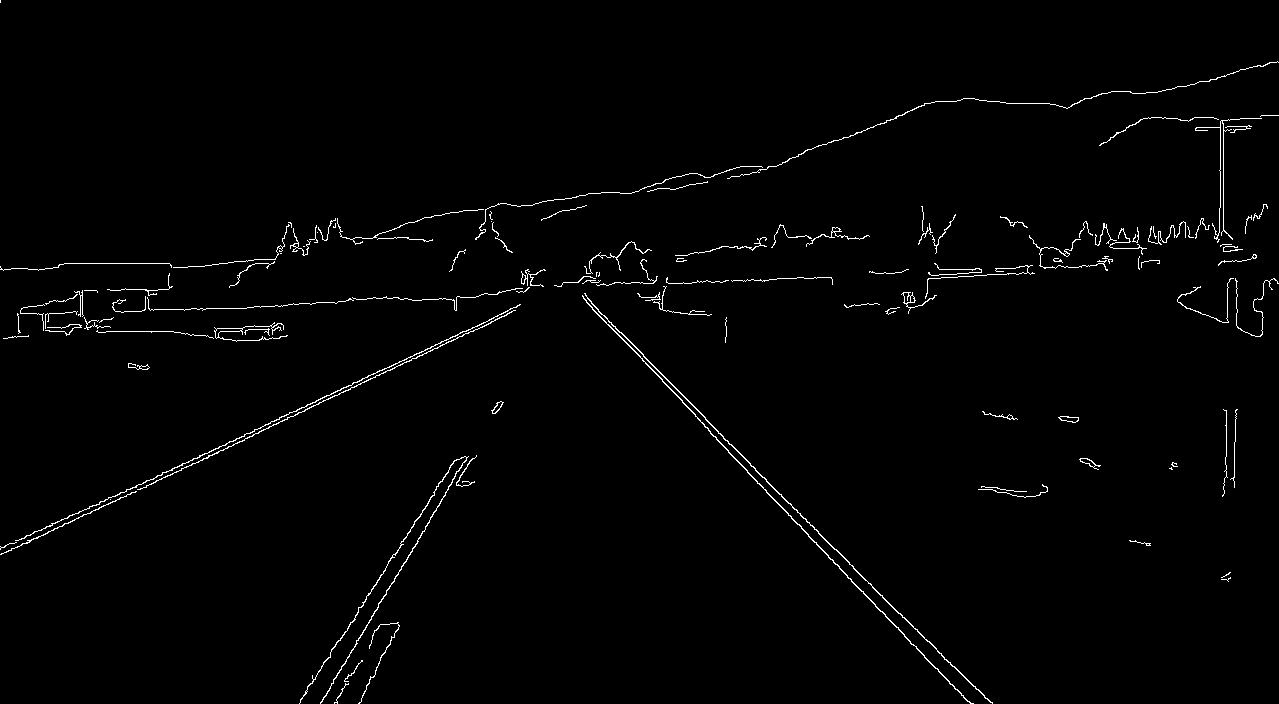

-1

In [44]:
image = cv2.imread("/content/drive/MyDrive/Automotive/test_image.jpg")
lane_image = np.copy(image)  #making copy of an image using numpy
canny=canny(lane_image)

cv2_imshow(canny)

cv2.waitKey(0)

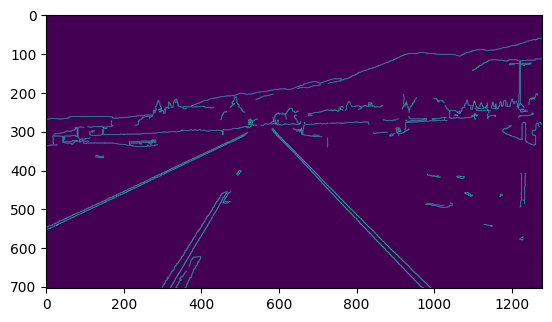

In [45]:
plt.imshow(canny)


#Region of interest

In [46]:
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
 
    triangle = np.array([[
    (200, height),
    (550, 250),
    (1100, height),]], np.int32)
 
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image                  


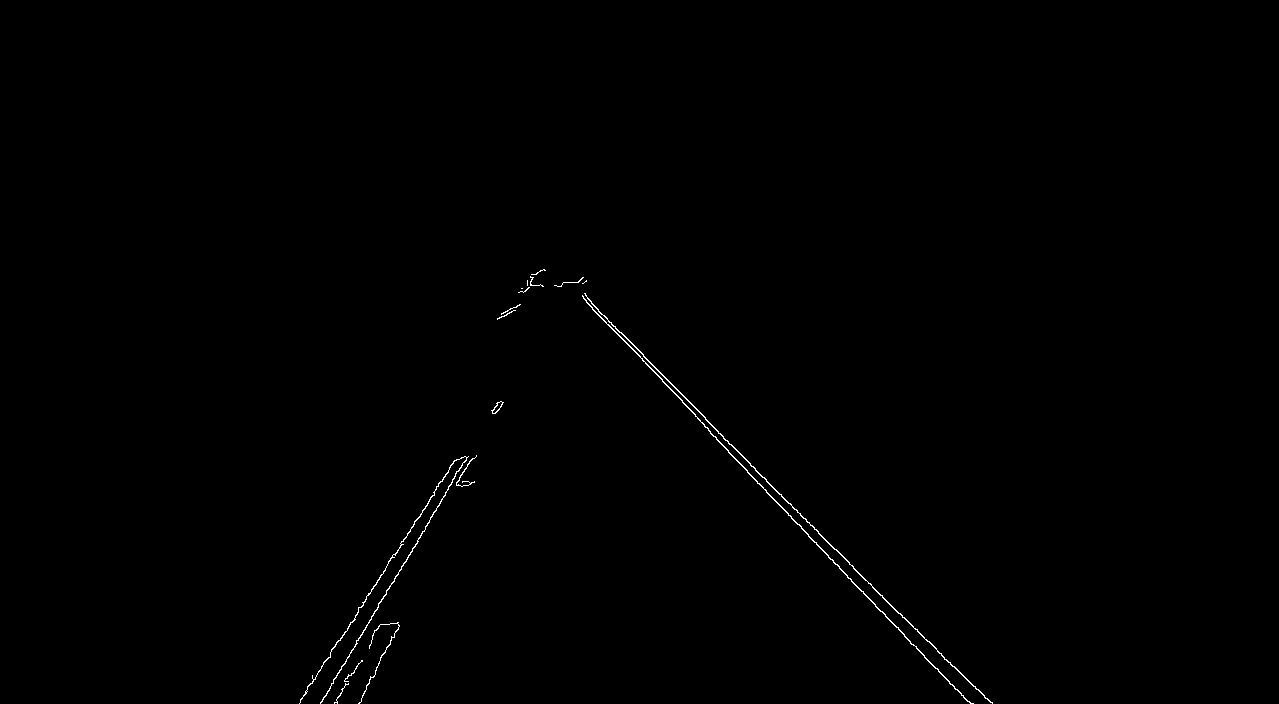

-1

In [47]:
cv2_imshow(region_of_interest(canny))

cv2.waitKey(0)

In [29]:
def display_lines(image, lines):
  line_image=np.zeros_like(image)
  if lines is not None:
    for line in lines:
      x1,y1,x2,y2=line.reshape(4)
      cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
  return line_image
  

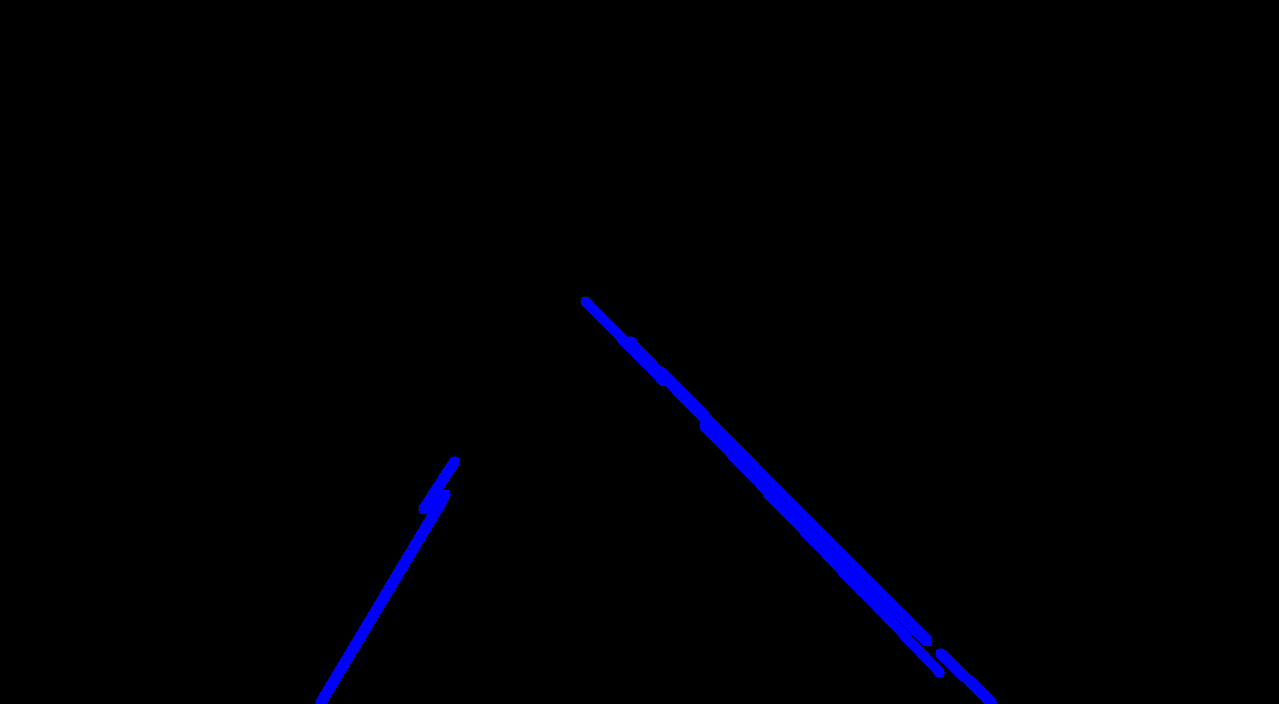

-1

In [30]:
cropped_image=region_of_interest(canny)
lines=cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
line_image=display_lines(lane_image, lines)

cv2_imshow(line_image)

cv2.waitKey(0)

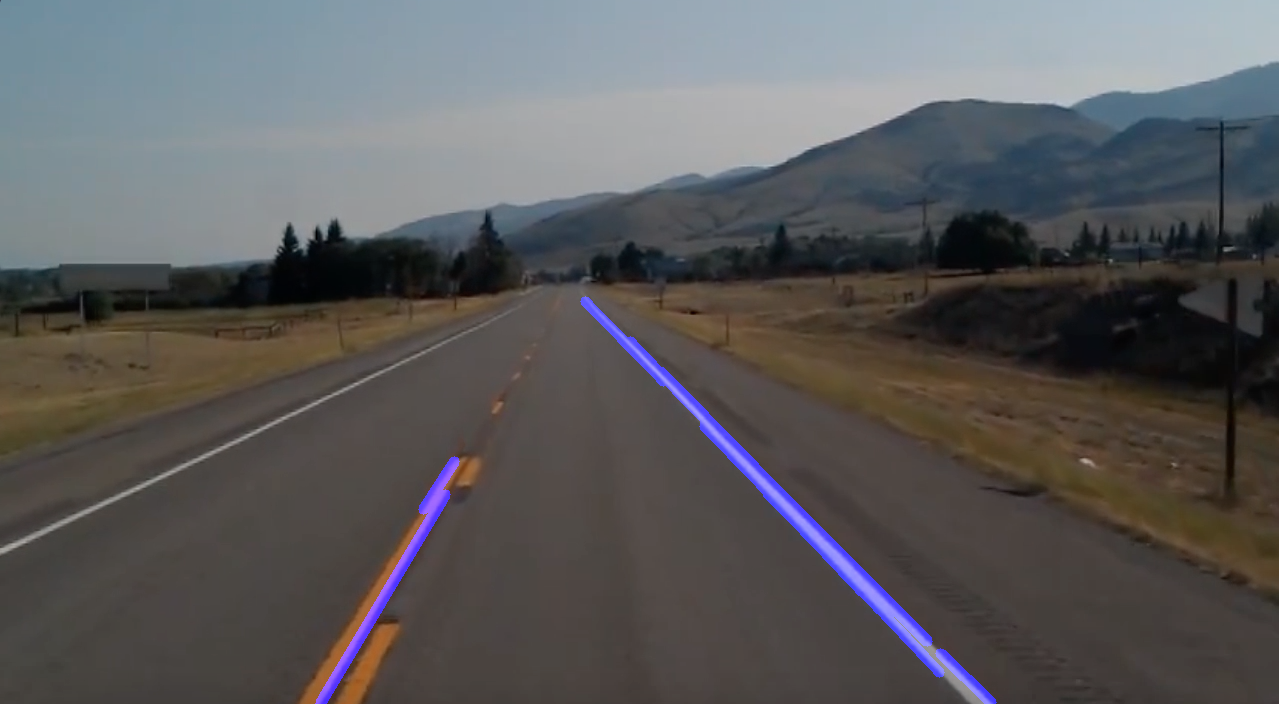

-1

In [31]:
combo_image=cv2.addWeighted(lane_image,0.8,line_image,1,1)

cv2_imshow(combo_image)

cv2.waitKey(0)

In [ ]:
def make_points(image, line):
    slope, intercept = line
    y1 = int(image.shape[0])# bottom of the image
    y2 = int(y1*3/5)         # slightly lower than the middle
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]
 
def average_slope_intercept(image, lines):
    left_fit    = []
    right_fit   = []
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            fit = np.polyfit((x1,x2), (y1,y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0: # y is reversed in image
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    # add more weight to longer lines
    left_fit_average  = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line  = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    averaged_lines = [left_line, right_line]
    return averaged_lines

In [56]:
cap = cv2.VideoCapture("/content/drive/MyDrive/Automotive/test2.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    canny_image = canny(frame)
    cropped_canny = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2_imshow(combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.